<a href="https://colab.research.google.com/github/aztofighi/Persian_Handwritten_Recognition/blob/main/Hoda_PyTorch_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Hoda_Test_20000.tar.gz
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Hoda_Train_60000.tar.gz

In [2]:
!tar xf Hoda_Train_60000.tar.gz
!tar xf Hoda_Test_20000.tar.gz

Epoch [1/2], Step [100/600], Loss: 0.1799
Epoch [1/2], Step [200/600], Loss: 0.0049
Epoch [1/2], Step [300/600], Loss: 0.1001
Epoch [1/2], Step [400/600], Loss: 0.0200
Epoch [1/2], Step [500/600], Loss: 0.0779
Epoch [1/2], Step [600/600], Loss: 0.0008
Epoch [2/2], Step [100/600], Loss: 0.0324
Epoch [2/2], Step [200/600], Loss: 0.0017
Epoch [2/2], Step [300/600], Loss: 0.0127
Epoch [2/2], Step [400/600], Loss: 0.0237
Epoch [2/2], Step [500/600], Loss: 0.0093
Epoch [2/2], Step [600/600], Loss: 0.0005


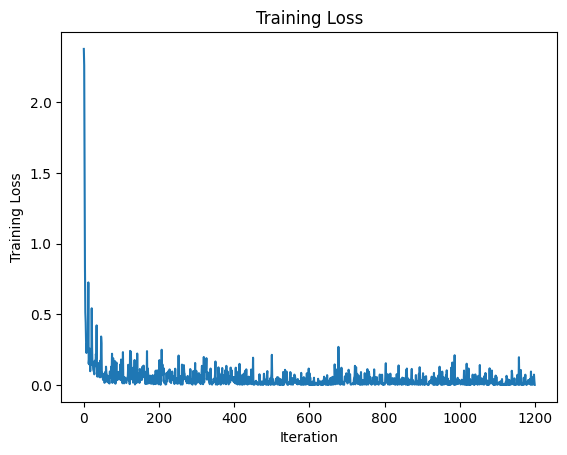

Accuracy of the model on the test images: 99.14 %


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# Data directories
train_dir = 'Hoda_Train_60000'
test_dir = 'Hoda_Test_20000'

# Transformation for image resizing and normalization
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset loaders
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# ResNet model
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
losses = []  # To store training loss for each epoch

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        losses.append(loss.item())  # Store the training loss

# Plotting the training loss
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))


In [17]:
# Save the trained model
checkpoint_dir = 'checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'resnet50_model.pth')
torch.save(model.state_dict(), checkpoint_path)
print("Trained model saved at:", checkpoint_path)

Trained model saved at: checkpoint/resnet50_model.pth


In [18]:
# Load the saved model
checkpoint_path = 'checkpoint/resnet50_model.pth'
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Assuming you have 10 classes
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)
model.eval()

# Class labels
class_labels = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']

Saving 8sample.png to 8sample (1).png


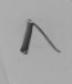

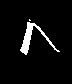

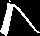

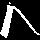

Predicted label: class_8


In [19]:
from google.colab import files
import io
from PIL import Image
from PIL import ImageOps
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet50
from matplotlib.pyplot import imshow

# Define the class labels
class_labels = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']

# Upload the image
upload_widget = files.upload()

# Load the pretrained model
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048, len(class_labels))
model.load_state_dict(torch.load('checkpoint/resnet50_model.pth'))
model = model.to(device)
model.eval()

# Process the uploaded image
for filename, file_contents in upload_widget.items():
    image = Image.open(io.BytesIO(file_contents)).convert('L')  # Convert to grayscale
    image1 = image
    image.show()
    # Convert image to binary
    binary_threshold = 128
    image = image.point(lambda x: 0 if x < binary_threshold else 255)
    
    # Convert image to negative
    image = Image.eval(image, lambda x: 255 - x)

    # Display the negative image
    image2 = image
    image.show()

    # Find the outmost non-zero pixel
    width, height = image.size
    left, top, right, bottom = width, height, 0, 0
    pixels = image.load()
    for y in range(height):
        for x in range(width):
            if pixels[x, y] > 0:
                left = min(left, x)
                top = min(top, y)
                right = max(right, x)
                bottom = max(bottom, y)

    # Crop the image to remove zero padding
    image_centered = image.crop((left, top, right + 1, bottom + 1))
    max_size = max(image_centered.size)


    
 
    image3 = image_centered
    image_centered.show()

    # Find the minimum and maximum height and width of the image
    min_size = min(image_centered.size)
    max_size = max(image_centered.size)

    # Calculate the padding size
    padding_size = max_size - min_size

    # Determine the side with the minimum size
    if image_centered.width == min_size:
        padding = (padding_size // 2, 0, padding_size - padding_size // 2, 0)  # Add padding horizontally
    else:
        padding = (0, padding_size // 2, 0, padding_size - padding_size // 2)  # Add padding vertically

    # Apply zero padding to the image
    padded_image = ImageOps.expand(image_centered, padding)

    image4 = padded_image
    padded_image.show()
    
    # Resize the image while maintaining aspect ratio
    resize_transform = transforms.Resize((32, 32))
    resized_image = resize_transform(padded_image)

    # Convert the image to RGB
    rgb_image = resized_image.convert('RGB')
    
    # Convert the image to tensor and normalize
    to_tensor_transform = transforms.ToTensor()
    image_tensor = to_tensor_transform(rgb_image).unsqueeze(0).to(device)
    image_tensor = (image_tensor - 0.5) / 0.5

    # Forward pass through the model
    with torch.no_grad():
        output = model(image_tensor)

    # Get the predicted class label
    _, predicted_idx = torch.max(output, 1)
    predicted_label = class_labels[predicted_idx.item()]

    print("Predicted label:", predicted_label)
